# Participation in this competition helps contribute to a meaningful cause 
As mentioned in the competition overview, "If successful, you'll help brain cancer patients receive less invasive diagnoses and treatments. The introduction of new and customized treatment strategies before surgery has the potential to improve the management, survival, and prospects of patients with brain cancer."

**Dataset**

The dataset is divided as follows: Each independent case has a dedicated folder identified by a five-digit number. Within each of these “case” folders, there are four sub-folders, each of them corresponding to each of the structural multi-parametric MRI (mpMRI) scans, in DICOM format. The exact mpMRI scans included are:

* Fluid Attenuated Inversion Recovery (FLAIR)
* T1-weighted pre-contrast (T1w)
* T1-weighted post-contrast (T1Gd)
* T2-weighted (T2)

**Files**

* train/ - folder containing the training files, with each top-level folder representing a subject. 
* train_labels.csv - file containing the target MGMT_value for each subject in the training data (e.g. the presence of MGMT promoter methylation)
* test/ - the test files, which use the same structure as train/; your task is to predict the MGMT_value for each subject in the test data. NOTE: the total size of the rerun test set (Public and Private) is ~5x the size of the Public test set
* sample_submission.csv - a sample submission file in the correct format

Each independent case is labeled with MGMT_value. 1 corresponds to the presence of MGMT (tumor) and 0 corresponds to absense.

## Understanding Dataset

For any Data Science project, it is crucial to understand the data, as best as possible, using visualization and Exploratory Data Analysis (EDA) techniques. 

Let's start with understanding the training labels file. But before that, let's make a cell to keep all the imported libraries in one place.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import copy
import cv2
import glob
import json
import matplotlib.pyplot as plt
import numpy as np # linear algebra
from operator import itemgetter
import os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import random
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models, transforms
import seaborn as sns

random.seed(37)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

EDA code taken from awesome work at https://www.kaggle.com/ihelon/brain-tumor-eda-with-animations-and-modeling

In [ ]:
#exploring distribution of training lables file
train_df = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")
train_df

In [ ]:
plt.figure(figsize=(5, 5))
sns.countplot(data=train_df, x="MGMT_value");

In [ ]:
def load_dicom(path):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data


def visualize_sample(
    brats21id, 
    slice_i,
    mgmt_value,
    types=("FLAIR", "T1w", "T1wCE", "T2w")
):
    plt.figure(figsize=(16, 5))
    patient_path = os.path.join(
        "../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/", 
        str(brats21id).zfill(5),
    )
    for i, t in enumerate(types, 1):
        t_paths = sorted(
            glob.glob(os.path.join(patient_path, t, "*")), 
            key=lambda x: int(x[:-4].split("-")[-1]),
        )
        data = load_dicom(t_paths[int(len(t_paths) * slice_i)])
        plt.subplot(1, 4, i)
        plt.imshow(data, cmap="gray")
        plt.title(f"{t}", fontsize=16)
        plt.axis("off")

    plt.suptitle(f"MGMT_value: {mgmt_value}", fontsize=16)
    plt.show()

In [ ]:
for i in random.sample(range(train_df.shape[0]), 10):
    _brats21id = train_df.iloc[i]["BraTS21ID"]
    _mgmt_value = train_df.iloc[i]["MGMT_value"]
    visualize_sample(brats21id=_brats21id, mgmt_value=_mgmt_value, slice_i=0.5)

In [2]:
train_path = '/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification'

We have several ideas for how to proceed, both 2D and 3D versions.  In order to properly test the 2D ones, it would be useful to have a single reference of all the good (as in, not blank) images *in order*, so that random or midpoint selection can easily grab them without having to process everything.  Ideally we can save this in a JSON file, where the main keys are patient IDs and the interior keys are modalities, with the inner values being ordered lists.

Several of these helper functions came from or were inspired by this notebook: https://www.kaggle.com/furcifer/no-baseline-pytorch-cnn-for-mri?scriptVersionId=68186710


In [3]:
#This is from the furcifer notebook
def _dicom2array(path, voi_lut=True, fix_monochrome=True, resize=False):
    dicom = pydicom.read_file(path)
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    #Normalize the data: subtract off the minimum, divide by the maximum, convert to 256 uint8
    data = data - np.min(data)
    data = data/np.max(data)
    data = (data * 255).astype(np.uint8)
    
    #Resize images to target value
    if resize:
        data = cv2.resize(data, (256, 256))
    return data

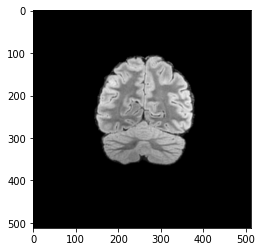

In [4]:
#To get an understanding of the what dcm files look like by manually changing the path
import matplotlib.pyplot as plt
from pydicom import dcmread
from pydicom.data import get_testdata_file

ds = dcmread('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/FLAIR/Image-119.dcm')
# plot the image using matplotlib
plt.imshow(ds.pixel_array, cmap=plt.cm.gray)
plt.show()

If one looks at the raw images, one sees lots of blank space around the actually brain, which is not useful for classification.  The following function finds the edges of the brain and eliminates the surrounding blank space.  Note: this is circumscribing it, not eliminating *all* the blank space, there is still blank space in the corners because PyTorch needs a cuboid input.

In [ ]:
#This cell was used to create the JSON file containing all of the images per modality in order with the blanks stripped out
#It also identified the "weirds", which are the patients where the DICOM images in at least one modality do not have the usual
#complement of features.  I'm not sure what to do with them at this time, so for now they are being excluded.

full_data_dict = {}
modes = ['FLAIR', 'T1w', 'T1wCE', 'T2w']
patients = glob.glob(f'{train_path}/train/*')
patient_IDs = sorted([p.split('/')[-1] for p in patients])
weirds = ['00109', '00157', '00170', '00186', '00353', '00367', '00414', '00561', '00563', '00564', '00565',
         '00756', '00834', '00839']
print('Number of Patients: ', len(patient_IDs))
print('First patient: ', patient_IDs[0])
print('Last patient: ', patient_IDs[-1])
for patient in patient_IDs:
    if patient in weirds:
        continue
    print('Patient ID: ', patient)
    subdict = {}
    for mode in modes:
        imgnames = glob.glob(f'{train_path}/train/{patient}/{mode}/*.dcm')
        if len(imgnames) == 0:
            subdict[mode] = []
            continue
        image_slice_locs = [pydicom.dcmread(im)[('0020', '1041')].value for im in imgnames]
        imgpairs = zip(imgnames, image_slice_locs)
        imgpairs = sorted(imgpairs, key=itemgetter(1))
        
        images = [f[0] for f in imgpairs]
        #print('Number of initial %s images: %i' % (mode, len(images)))
        real_images = [_dicom2array(f) for f in images]
        good_indices = [idx for idx,image in enumerate(real_images) if np.max(image) > 0]
        good_imnames = [im for idx,im in enumerate(images) if idx in good_indices]
        if len(good_imnames) == 0:
            subdict[mode] = []
            continue
        
        final_imnames = [imname.split('/')[-1] for imname in good_imnames]
    
        #print('Number of final images: ', len(final_imnames))
        subdict[mode] = final_imnames
    full_data_dict[patient] = subdict

In [ ]:
#This is the cell that actually wrote the JSON file, using the dictionary from the above cell
#with open('all_valid_image_names.json', 'w') as outfile:
#    json.dump(full_data_dict, outfile)

In [5]:
#Access the JSON file with all of the sorted good images
f = open('../input/brain-tumor-valid-images-in-order/all_valid_image_names.json')
good_image_names = json.load(f)
print('Number of Patients with good images: ', len(good_image_names))

Number of Patients with good images:  571


In [6]:
#Eliminate as much blank space around a 2D slice as possible
def _circumscriber2D(img: np.array) -> np.array:
    vmin = 0
    hmin = 0
    vlimit, hlimit = img.shape
    
    for i in range(vlimit):
        if np.max(img[i, :]) == 0:
            vmin += 1
        else:
            break
    vmax = vmin + 1
    for i in range(vmin+1, vlimit):
        if np.max(img[i, :]) > 0:
            vmax += 1
        else:
            break

    for j in range(hlimit):
        if np.max(img[:, j]) == 0:
            hmin += 1
        else:
            break
    hmax = hmin + 1
    for j in range(hmin+1, hlimit):
        if np.max(img[:, j]) > 0:
            hmax += 1
        else:
            break
    return img[vmin: vmax, hmin:hmax]

In [7]:
#Eliminate as much blank space around a 3D cube as possible.  This one assumes the purely blank slices were already filtered out
def _circumscriber3D(img: np.array) -> np.array:
    #First is vertical, second is horizontal, third is slices
    vmin = 0
    vlimit = img.shape[0]
    hmin = 0
    hlimit = img.shape[1]
    
    for i in range(vlimit):
        if np.max(img[i, :, :]) == 0:
            vmin += 1
        else:
            break
    vmax = vmin + 1
    for i in range(vmin+1, vlimit):
        if np.max(img[i, :, :]) > 0:
            vmax += 1
        else:
            break
    
    for j in range(hlimit):
        if np.max(img[:, j, :]) == 0:
            hmin += 1
        else:
            break
    hmax = hmin + 1
    for j in range(hmin+1, hlimit):
        if np.max(img[:, j, :]) > 0:
            hmax += 1
        else:
            break
    return img[vmin:vmax, hmin:hmax, :]

This is the Cutout data augmenter: when active, it will randomly zero out cubes of the brain image.  My guess is that, with the proper block size ('side' parameter), this will be a more effective regularizer than SliceSkip, but I could be mistaken.
Besides the size of the blocks, the number of dropped blocks will likely also matter a fair bit, but I'll add that functionality later.  I have changed the name from DropBlock to Cutout in keeping with the convention described in the DropBlock paper: https://arxiv.org/pdf/1810.12890.pdf
The full DropBlock regularizer applies this to all the feature maps produced by the convolutional layers, whereas what I'm doing here is making random changes to the input.

In [19]:
def _Cutout(img: np.array, side: int) -> np.array:
    ycap = img.shape[0] - side
    xcap = img.shape[1] - side
    
    nholes = random.randint(1, 5)
    ycorners = random.sample(range(0, ycap), nholes)
    xcorners = random.sample(range(0, xcap), nholes)
    
    if len(img.shape) == 3:
        dcap = img.shape[2] - min(side, img.shape[2])
        if dcap == 0:
            dcorners = [0] * nholes
        else:
            dcorners = random.sample(range(0, dcap), nholes)
    
    for i in range(nholes):
        if len(img.shape) == 3:
            img[ycorners[i]:ycorners[i]+side, xcorners[i]:xcorners[i]+side, dcorners[i]:dcorners[i]+side] = 0
        else:
            img[ycorners[i]:ycorners[i]+side, xcorners[i]:xcorners[i]+side] = 0
    
    return img

In [9]:
def load_single_slice(patient_id, split='train', modality='FLAIR', position=0, cutout=False):
    """
    Load in a single slice for a given patient, of a given modality and position within the line-up
    """
    if split != 'train' and split != 'test':
        print('Please request a valid split: train or test. Defaulting to train')
        split='train'
        
    if modality not in ['FLAIR', 'T1w', 'T1wCE', 'T2w']:
        print('Please choose a valid modality: FLAIR, T1w, T1wCE, or T2w. Defaulting to FLAIR')
        modality = 'FLAIR'
        
    available_images = good_image_names[patient_id][modality]
    if len(available_images) == 0:
        print('There doesnt seem to be anything here! Lets go back and tell Master Luke...')
        print('Patient ID: ', patient_id)
        print('Modality: ', modality)
        return None
    
    if position == 'middle':
        position = int(len(available_images) * 0.5)
    
    #print('Number of Available Images: ', len(available_images))
    if position >= len(available_images):
        print('Please choose an acceptable position, must be no more than: ', len(available_images) - 1)
        print('Defaulting to middle position')
        position = int(len(available_images) * 0.5)

    imname = available_images[position]
    #print('imname: ', imname)
    image_path = f'{train_path}/{split}/{patient_id}/{modality}/{imname}'
    image = glob.glob(image_path)[0]
    real_image = _dicom2array(image)
    #print('real_image shape: ', real_image.shape)
    final_image = _circumscriber2D(real_image).T
    #print('final_image shape: ', final_image.shape)
    if cutout:
        final_image = _Cutout(final_image, 5)
    return final_image
    

In [10]:
#This was inspired by load_rand_dicom_images in the furcifer notebook
def load_FULL_brain(scan_id, split = 'train', modality='FLAIR', sliceSkip=0.0, cutOut=False):
    """
    send all of the images in the chosen modality, in order, as a single 3D np array
    """
    if split != "train" and split != "test":
        print('Please request a valid split: train or test.  Defaulting to train.')
        split = "train"
        
    if modality != 'FLAIR' and modality != 'T1w' and modality != 'T1wCE' and modality != 'T2w':
        print('Please select an appropriate modality: FLAIR, T1w, T1wCE, or T2w')
        print('Defaulting to FLAIR')
        modality = 'FLAIR'
        
    if sliceSkip >= 1:
        sliceSkip = 0
        print('Please choose a valid sliceSkip number, from 0 to 1 inclusive/exclusive')
        
    image = sorted(glob.glob(f'{train_path}/{split}/{scan_id}/{modality}/*.dcm'))
    nKeep = int(len(image) * (1 - sliceSkip))
    image = random.sample(image, nKeep)
    
    image_slice_locs = [pydicom.dcmread(im)[('0020', '1041')].value for im in image]
    image_pairs = list(zip(image, image_slice_locs))
    ordered_IP = sorted(image_pairs, key=itemgetter(1))
    images = [f[0] for f in ordered_IP]
    real_images = [_dicom2array(f) for f in images]
    good_images = np.array([im for im in real_images if np.max(im) > 0]).T
    final_image = _circumscriber3D(good_images)
    
    #Only use Cutout data augmentation if explicitly desired
    if cutOut:
        final_image = _Cutout(final_image, 10)
    
    return final_image

In [ ]:
#This was copy-pasted from the furcifer notebook
def plot_imgs(imgs, cols=4, size=7, is_rgb=True, title="", cmap='gray', img_size=(512,512)):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i in range(4):
        img = imgs[:,:,i]
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

In [ ]:
boxtest = load_FULL_brain('00000', split='train', modality='FLAIR', sliceSkip=0.0, cutOut=True)

Let's have a look at four slices from the middle of patient 00000's FLAIR brain image.

In [ ]:
plot_imgs(boxtest[:,:,100:104])

In [11]:
class SliceLoader(Dataset):
    def __init__(self, label_file, path, split, modality, position=None, exclude=None, val_split=0.25,
                transform = None, cutout=False):
        train_data = pd.read_csv(os.path.join(path, label_file))
        self.labels = {}
        self.path = path
        brats = list(train_data['BraTS21ID'])
        mgmt = list(train_data['MGMT_value'])
        for b, m in zip(brats, mgmt):
            self.labels[str(b).zfill(5)] = m
            
        self.split = split
        self.modality = modality
        self.position = position
        self.exclude = exclude
        self.transform = transform
        self.cutout = cutout
        splitdir = 'train'
        if self.split == 'test':
            splitdir = 'test'
        self.ids = [a.split('/')[-1] for a in sorted(glob.glob(path + f'/{splitdir}/*'))]
        stop = int(len(self.ids) * (1 - val_split))
        if split == 'train':
            self.ids = self.ids[:stop]
        elif split == 'val':
            self.ids = self.ids[stop:]
            
        self.ids = [a for a in self.ids if a not in self.exclude]
            
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        p_id = self.ids[idx]
        if not self.position:
            available_images = good_image_names[p_id][self.modality]
            position = int(len(available_images) * 0.5) #Grab the middle slice if one not selected
        else:
            position = self.position
            
        if self.split == 'val':
            self.split = 'train'
        image = load_single_slice(p_id, self.split, self.modality, position, self.cutout)
        image_triple = np.stack([image, image, image]).T
        transform = self.transform
        image = transform(image_triple)
        
        if self.split != 'test':
            label = torch.tensor(self.labels[p_id], dtype=torch.long)
            return torch.tensor(image, dtype=torch.float32), label
        return torch.tensor(image, dtype=torch.float32)

In [28]:
class MultiSliceLoader(Dataset):
    def __init__(self, label_file, path, modality, num_slices=1, split='train', good_images=None, exclude=None, 
                 val_split=0.25, transform=None, cutout=False):
        train_data = pd.read_csv(os.path.join(path, label_file))
        self.labels = {}
        self.path = path
        brats = list(train_data['BraTS21ID'])
        mgmt = list(train_data['MGMT_value'])
        for b, m in zip(brats, mgmt):
            self.labels[str(b).zfill(5)] = m
            
        self.split = split
        self.modality = modality
        self.num_slices = num_slices
        self.good_images = good_images
        self.exclude = exclude
        self.transform = transform
        self.cutout = cutout
        self.splitdir = 'train'
        if self.split == 'test':
            self.splitdir = 'test'
        self.ids = [a.split('/')[-1] for a in sorted(glob.glob(path + f'/{self.splitdir}/*'))]
        stop = int(len(self.ids) * (1 - val_split))
        if split == 'train':
            self.ids = self.ids[:stop]
        elif split == 'val':
            self.ids = self.ids[stop:]
            
        self.ids = [a for a in self.ids if a not in self.exclude]
    
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        p_id = self.ids[idx]
        mode = self.modality
        patient_images = self.good_images[p_id][mode]
        
        n_available = len(patient_images)
        if n_available == 0:
            print('There doesnt seem to be anything here! Lets go back and tell Master Luke...')
            return None
        
        if n_available < self.num_slices:
            image = load_FULL_brain()
            
        first = int(n_available * 0.5) - int(self.num_slices * 0.5)
        last = int(n_available * 0.5) + int(self.num_slices * 0.5)
        if n_available % 2 == 0:
            first -= 1 
        
        targets = patient_images[first:last]
        target_paths = [f'{train_path}/{self.splitdir}/{p_id}/{mode}/{t}' for t in targets]
        image = np.stack([_dicom2array(p) for p in target_paths]).T
        if self.cutout:
            image = _Cutout(image, 5)
        
        transform = self.transform
        image = transform(image)
        
        if self.split != 'test':
            label = torch.tensor(self.labels[p_id], dtype=torch.long)
            return torch.tensor(image, dtype=torch.float32), label
        return torch.tensor(image, dtype=torch.float32)

In [22]:
weirds = ['00109', '00157', '00170', '00186', '00353', '00367', '00414', '00561', '00563', '00564', '00565', '00709',
         '00756', '00834', '00839']

In [33]:
#Let's see if MultiSliceLoader works...
NUM_SLICES = 5
train_bs = 1
train_dataset = MultiSliceLoader('train_labels.csv', train_path, modality='FLAIR', num_slices=NUM_SLICES, split='train',
                                 good_images=good_image_names, exclude=weirds, transform=chosen_transforms['train'])
train_loader = DataLoader(train_dataset, batch_size=train_bs, shuffle=True)

for img, label in train_loader:
    print('---------------Iteration---------------------')
    print(img.shape)
    print(img.min())
    print(img.mean())
    print(img.max())
    print(label.shape)
    break

---------------Iteration---------------------
torch.Size([1, 5, 480, 640])
tensor(-1.9867)
tensor(-1.4871)
tensor(2.4381)
torch.Size([1])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [32]:
#Normalization terms, because we are using a model pretrained on ImageNet
#mean_nums = [0.485, 0.456, 0.406]
#std_nums = [0.229, 0.224, 0.225]
pure_mean = 0.449
pure_std = 0.226
means = [pure_mean] * NUM_SLICES
stds = [pure_std] * NUM_SLICES

#Apply transformations for data augmentation
chosen_transforms = {'train': transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=90),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(means, stds)
]),
   'val': transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize(means, stds)
   ])}

In [ ]:
#Let's see if SliceLoader can actually load slices
train_bs = 1
train_dataset = SliceLoader('train_labels.csv', train_path, split='train', modality='FLAIR', position=17, exclude=weirds, 
                           transform=chosen_transforms['train'])
train_loader = DataLoader(train_dataset, batch_size=train_bs, shuffle=True)

for img, label in train_loader:
    print('---------------Iteration---------------------')
    print(img.shape)
    print(img.min())
    print(img.mean())
    print(img.max())
    print(label.shape)
    break

In [ ]:
labels = pd.read_csv(os.path.join(train_path, 'train_labels.csv'))
labels.head()

In [ ]:
#This was inspired by the BrainTumor Dataset class in the furcifer notebook, though I have heavily modified it.
class BrainLoader(Dataset):
    def __init__(self, label_file, path, split, modality, skip=0.0, cutout=False, val_split=0.25):
        train_data = pd.read_csv(os.path.join(path, label_file))
        self.labels = {}
        self.path = path
        brats = list(train_data['BraTS21ID'])
        mgmt = list(train_data['MGMT_value'])
        for b, m in zip(brats, mgmt):
            self.labels[str(b).zfill(5)] = m
            
        splitdir = 'train'
        self.split = split
        if self.split == 'test':
            splitdir = 'test'
        self.modality = modality
        
        self.skip = skip
        self.cutout = cutout
        if self.split != 'train':
            self.skip = 0
            self.drop = cutout
        
        self.ids = [a.split('/')[-1] for a in sorted(glob.glob(path + f'/{splitdir}/*'))]
        stop = int(len(self.ids) * (1 - val_split))
        if split == 'train':
            self.ids = self.ids[:stop]
        elif split == 'val':
            self.ids = self.ids[stop:]
            
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        p_id = self.ids[idx]
        imgs = load_FULL_brain(p_id, split=self.split, modality=self.modality, sliceSkip=self.skip, cutOut=self.cutout)
        transform = transforms.Compose([transforms.ToTensor()])
        imgs = transform(imgs)
        
        if self.split != 'test':
            label = torch.tensor(self.labels[p_id], dtype=torch.long)
            return torch.tensor(imgs, dtype=torch.float32), label
        return torch.tensor(imgs, dtype=torch.float32)

Finally, let's test out BrainLoader.

In [ ]:
train_bs = 1
train_dataset = BrainLoader('train_labels.csv', train_path, split='train', modality='T1w', skip=0.0, cutout=True)

train_loader = DataLoader(train_dataset, batch_size=train_bs, shuffle=True)

for img, label in train_loader:
    print('Iteration')
    print(img.shape)
    print(img.min())
    print(img.mean())
    print(img.max())
    print(label.shape)
    break

Alright, now that we have the loader pretty well set up, we need an actual model or four to train.  This seems like a valuable source: https://pytorch.org/hub/ 

In [ ]:
#Simple Resnet-18 model, pretrained on ImageNet.  Let's see what it can do...
model_dummy = models.resnet18(pretrained=True)
num_ftrs = model_dummy.fc.in_features
# Here the size of each output sample is set to 2.
model_dummy.fc = nn.Linear(num_ftrs, 2)

In [14]:
model_resnet50 = models.resnet50(pretrained=True)
num_ftrs = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(num_ftrs, 2)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

We want to modify the model to take an arbitrary number of slices as input channels. For a handful of adjacent slices, these are treated as different "color channels" of the same image, but for more than 3 or 4 we want to modify the actual structure of the model to use 3D convolutions instead.  Those models will be more complex but should be more effective because they'll take advantage of 3D structural information.  
To change the number of input channels, follow the instructions here: https://discuss.pytorch.org/t/how-to-modify-the-input-channels-of-a-resnet-model/2623/10

In [15]:
print(model_resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
layer = model_resnet50.conv1

# Creating new Conv2d layer
new_layer = nn.Conv2d(in_channels=NUM_SLICES, 
                  out_channels=layer.out_channels, 
                  kernel_size=layer.kernel_size, 
                  stride=layer.stride, 
                  padding=layer.padding,
                  bias=layer.bias)

copy_weights = 0 # Here will initialize the weights from new channel with the red channel weights

# Copying the weights from the old to the new layer
new_layer.weight[:, :layer.in_channels, :, :] = layer.weight.clone()

#Copying the weights of the `copy_weights` channel of the old layer to the extra channels of the new layer
for i in range(NUM_SLICES - layer.in_channels):
    channel = layer.in_channels + i
    new_layer.weight[:, channel:channel+1, :, :] = layer.weight[:, copy_weights:copy_weights+1, : :].clone()
new_layer.weight = nn.Parameter(new_layer.weight)

model_resnet50.conv1 = new_layer

In [ ]:
train_bs = 1
val_bs = 1
train_dummy = SliceLoader('train_labels.csv', train_path, split='train', modality='FLAIR', position='middle', exclude=weirds,
                         transform = chosen_transforms['train'], cutout=False)
val_dummy = SliceLoader('train_labels.csv', train_path, split='val', modality='FLAIR', position='middle', exclude=weirds,
                       transform = chosen_transforms['val'])
train_loader = DataLoader(train_dummy, batch_size=train_bs, shuffle=True)
val_loader = DataLoader(val_dummy, batch_size=val_bs, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader}

n_images = 0
n_rand = 0
n_correct = 0

for img, label in val_loader:
    n_images += 1
    if n_images > 5:
        break
    #print('img shape: ', img.shape)

    out = model_resnet50(img)
    print('out: ', out)
    _,pred = torch.max(out, dim=1)
    randpred = random.choice([0,1])
    print('pred: ', pred)
    print('out[0][pred]: ', out[0][pred])
    if pred == label:
        n_correct += 1
    if randpred == label:
        n_rand += 1
        
print('Correct: ', n_correct)
print('Random Correct: ', n_rand)
print('Total: ', n_images)

Alright, let's add a training loop, without a training loop we don't really have anything.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset_sizes = {'train': 427, 'val': 143}
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_resnet50.parameters(), lr=1e-4)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)
model_resnet50 = model_resnet50.to(device)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, device='cpu'):
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            for img, label in dataloaders[phase]:
                #Send everything to the relevant device
                img = img.to(device)
                #label = label.float()
                label = label.to(device)
                
                #Zero the parameter gradients
                optimizer.zero_grad()
                
                #Forward pass, track history only in train mode
                with torch.set_grad_enabled(phase == 'train'):
                    output = model(img)
                    _, pred = torch.max(output, dim=1)
                    loss = criterion(output, label)
                 
                
                    #Backward pass, optimize only in training mode
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item() * img.size(0)
                running_corrects += torch.sum(pred == label.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
    

In [ ]:
FT_model = train_model(model_resnet50, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25, device=device)